# Analyse des données médiatiques d'Apple

In [1]:
import pandas as pd
import requests
from datetime import datetime, timedelta
import time
import zipfile
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
from scipy import stats
warnings.filterwarnings('ignore')

On veut récupérer le nombre de mentions médiatiques (dans des articles) d'Apple à partir des données GDELT 2.0.

In [12]:
class GDELTMediaScore:
    """Analyse de la couverture médiatique d'Apple via GDELT 2.0"""
    
    def __init__(self):
        self.base_url = "http://data.gdeltproject.org/gdeltv2/"
        self.results = []
        
    def generate_file_urls(self, start_date, end_date):
        """Génère les URLs des fichiers GDELT pour la période"""
        urls = []
        # GDELT 2.0 a commencé le 19 février 2015
        actual_start = max(start_date, datetime(2015, 2, 19))
        current = actual_start
        
        while current <= end_date:
            # Fichier de midi (plus de chances d'avoir des données)
            timestamp = current.strftime("%Y%m%d120000")
            url = f"{self.base_url}{timestamp}.gkg.csv.zip"
            urls.append((current, url))
            current += timedelta(days=1)
            
        return urls
    
    def download_and_parse(self, date, url, max_retries=2):
        """
        Télécharge et analyse un fichier GDELT pour un jour donné,
        en version ultra-optimisée (sans pandas).
        """
        for attempt in range(max_retries):
            try:
                print(f"{date.strftime('%Y-%m-%d')}...", end=" ")

                # Téléchargement (sans stream + content direct)
                response = requests.get(url, timeout=20)
                if response.status_code == 404:
                    print("✗", end=" ")
                    return None

                response.raise_for_status()

                # Ouverture du ZIP en mémoire
                with zipfile.ZipFile(BytesIO(response.content)) as zf:
                    csv_filename = zf.namelist()[0]

                    mentions_count = 0
                    tones = []
                    sources = set()

                    # Lecture ligne par ligne du TSV compressé
                    with zf.open(csv_filename) as f:
                        for raw_line in f:
                            try:
                                line = raw_line.decode('utf-8', errors='ignore').rstrip('\n')
                            except UnicodeDecodeError:
                                # Au cas où, mais normalement couvert par errors='ignore'
                                continue

                            # Split tabulé (GDELT GKG = TSV)
                            parts = line.split('\t')
                            # On vérifie qu'on a bien assez de colonnes (indice max = 15)
                            if len(parts) <= 15:
                                continue

                            # Colonnes utiles (indices d'après ton usecols)
                            # 1  : DATE
                            # 3  : SourceCommonName
                            # 13 : Organizations
                            # 14 : V2Organizations
                            # 15 : V2Tone
                            source_name = parts[3]
                            org = parts[13] or ""
                            v2org = parts[14] or ""
                            tone_str = parts[15] or ""

                            # Filtre "Apple" (en minuscules, sans regex)
                            org_low = org.lower()
                            v2org_low = v2org.lower()
                            if ("apple" not in org_low) and ("apple" not in v2org_low):
                                continue

                            # À partir d'ici : on a une mention d'Apple
                            mentions_count += 1

                            # Source
                            if source_name:
                                sources.add(source_name)

                            # Tone = premier champ avant la virgule
                            if tone_str:
                                first_field = tone_str.split(',')[0]
                                try:
                                    tone_val = float(first_field)
                                    if -10.0 <= tone_val <= 10.0:
                                        tones.append(tone_val)
                                except ValueError:
                                    pass

                if mentions_count > 0 and tones:
                    tones_arr = np.array(tones, dtype=float)
                    pos_ratio = float((tones_arr > 0).sum()) / len(tones_arr)

                    result = {
                        'date': date,
                        'mentions': mentions_count,
                    }
                    print(f"✓ {mentions_count}", end=" ")
                    return result

                print("∅", end=" ")
                return None

            except zipfile.BadZipFile:
                print("✗(zip)", end=" ")
                return None
            except Exception as e:
                # Erreurs "bizarres" liées à la taille / parsing → on abandonne
                msg = str(e).lower()
                if "buffer overflow" in msg or "tokenizing" in msg:
                    print("✗(size)", end=" ")
                    return None

                if attempt < max_retries - 1:
                    time.sleep(1)
                else:
                    print(f"✗({type(e)._name_})", end=" ")

        return None

    def collect_data(self, start_date, end_date, sample_rate=7):
        """
        Collecte les données GDELT 2.0
        sample_rate: prendre 1 jour tous les N jours
        """
        print(f"\n{'='*70}")
        print(f"COLLECTE DONNÉES GDELT 2.0 - APPLE")
        print(f"{'='*70}")
        print(f"Période: {start_date.strftime('%Y-%m-%d')} à {end_date.strftime('%Y-%m-%d')}")
        print(f"Échantillonnage: 1 jour / {sample_rate}")
        print(f"Note: GDELT 2.0 commence le 19 février 2015")

        urls = self.generate_file_urls(start_date, end_date)
        sampled_urls = urls[::sample_rate]

        print(f"Fichiers à analyser: {len(sampled_urls)}")
        print(f"\nLégende: ✓=données, ✗=absent, ∅=aucune mention\n")

        self.results = []  # au cas où tu relances plusieurs fois

        for i, (date, url) in enumerate(sampled_urls, start=1):
            result = self.download_and_parse(date, url)
            if result is not None:
                self.results.append(result)

            if i % 10 == 0 or i == len(sampled_urls):
                print(f" [{i}/{len(sampled_urls)}]")

        print(f"\n\n{'='*70}")
        print(f"✓ Collecte terminée: {len(self.results)} jours avec mentions Apple")
        print(f"{'='*70}\n")
    
    
    def visualize(self, df):
        """Génère la visualisation du volume de mentions"""
        fig, ax = plt.subplots(figsize=(14, 6))
        
        # Volume de mentions
        ax.bar(df['date'], df['mentions'], width=5, color='#34C759', alpha=0.7, edgecolor='#2A8F3F')
        ax.set_title('📰 Volume de Mentions Apple dans les Médias', fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Date', fontsize=13)
        ax.set_ylabel('Nombre de mentions', fontsize=13)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Ajouter des statistiques sur le graphique
        mean_mentions = df['mentions'].mean()
        max_mentions = df['mentions'].max()
        ax.axhline(y=mean_mentions, color='red', linestyle='--', linewidth=2, alpha=0.7,
                label=f'Moyenne: {mean_mentions:.0f}')
        
        ax.legend(loc='upper left', fontsize=11)
        
        plt.tight_layout()
        plt.show()

On s'intéresse à la période 2015 (début des données GDELT 2.0) - 2025, on collecte les données avec un oas de 14 jours sinon le code est trop long à faire tourner.

In [ ]:
if __name__ == "__main__":
    
    analyzer = GDELTMediaScore()
    
    # Période d'analyse
    start = datetime(2015, 2, 19)  # Début de GDELT 2.0
    end = datetime(2025, 11, 30)
    
    # Collecte (échantillonnage: 1 jour/semaine pour test rapide)
    # Changez à sample_rate=1 pour avoir TOUS les jours (long!)
    analyzer.collect_data(start, end, sample_rate=14)


COLLECTE DONNÉES GDELT 2.0 - APPLE
Période: 2015-02-19 à 2025-11-30
Échantillonnage: 1 jour / 14
Note: GDELT 2.0 commence le 19 février 2015
Fichiers à analyser: 282

Légende: ✓=données, ✗=absent, ∅=aucune mention

2015-02-19... ✓ 2 2015-03-05... ✓ 5 2015-03-19... ✓ 3 2015-04-02... ✓ 6 2015-04-16... ✓ 4 2015-04-30... ✓ 6 2015-05-14... ✓ 4 2015-05-28... ✓ 1 2015-06-11... ✓ 2 2015-06-25... ✓ 1  [10/282]
2015-07-09... ✓ 2 2015-07-23... ✓ 10 2015-08-06... ✓ 5 2015-08-20... ✓ 6 2015-09-03... ✓ 12 2015-09-17... ✓ 5 2015-10-01... ✓ 5 2015-10-15... ✓ 12 2015-10-29... ✓ 11 2015-11-12... ✓ 5  [20/282]
2015-11-26... ✓ 3 2015-12-10... ✓ 1 2015-12-24... ✓ 7 2016-01-07... ✓ 3 2016-01-21... ✓ 7 2016-02-04... ✓ 3 2016-02-18... ✓ 11 2016-03-03... ✓ 3 2016-03-17... ✓ 7 2016-03-31... ✓ 7  [30/282]
2016-04-14... ✓ 5 2016-04-28... ✓ 14 2016-05-12... ✓ 2 2016-05-26... ✓ 3 2016-06-09... ✓ 9 2016-06-23... ✓ 7 2016-07-07... ✓ 8 2016-07-21... ✓ 23 2016-08-04... ✓ 7 2016-08-18... ✓ 7  [40/282]
2016-09-01... ✓ 7

AttributeError: 'GDELTMediaScore' object has no attribute 'calculate_media_score'

In [ ]:
df_media = pd.DataFrame(analyzer.results)
df_media['date'] = pd.to_datetime(df_media['date'])
df_media = df_media.sort_values('date').reset_index(drop=True)

# Export
export_df = df_media[['date', 'mentions']].copy()
export_df.to_csv("apple_media.csv", index=False)

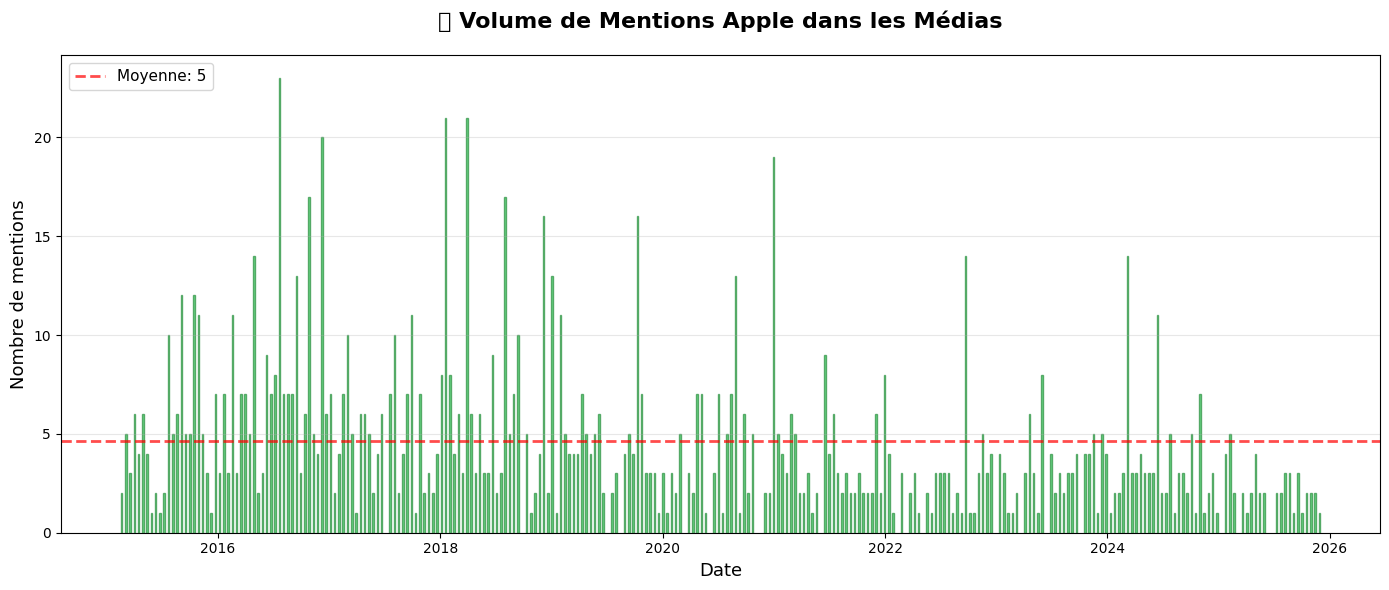

In [ ]:
analyzer = GDELTMediaScore()
df_finance = pd.read_csv("..\data\dataset_with_feature.csv")
#df_media = pd.read_csv("..\data\apple_media.csv")

analyzer.visualize(df_media)

Les pics de mentions médiatiques s'expliquent souvent soit par le lancement de nouveaux produits ou bien par des affaires extérieures qui concernent Apple, on trouve notamment :
- Entre 2015 et 2017 : lancement des airpods, lancement de l'iPhone X, conflit avec le FBI (San Bernadino), scandale "Batterygate".
- Entre 2018 et 2020 : lancements des iPhone XR/XS, WWDC, transition vers les puces Apple Silicon, bataille juridique avec Epic Games, débat App Store
- Depuis 2021 : annonce apple vision pro, annonces liés à l'IA générative, controverse CSAM, obligation de se conformer au DMA

On veut ensuite observer les relations avec le rendement, la volatilité, le volume.

In [22]:
class MediaFinanceCorrelation:
    """Analyse des corrélations entre score médiatique et données financières"""
    
    def __init__(self, df_finance, df_media):
        """
        Parameters:
        -----------
        df_finance : DataFrame avec colonnes ['Date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']
        df_media : DataFrame du score médiatique avec colonnes ['date', 'media_score', ...]
        """
        self.df_finance = df_finance.copy()
        self.df_media = df_media.copy()
        self.df_merged = None
        
    def prepare_data(self):
        """Fusionne les datasets et prépare les données"""
        
        # Affichage des colonnes pour debug
        
        # Normalisation des colonnes de date pour df_finance
        if 'Date' in self.df_finance.columns:
            self.df_finance['date'] = pd.to_datetime(self.df_finance['Date'])
        elif 'date' in self.df_finance.columns:
            self.df_finance['date'] = pd.to_datetime(self.df_finance['date'])
        else:
            # Date dans l'index
            self.df_finance = self.df_finance.reset_index()
            if 'Date' in self.df_finance.columns:
                self.df_finance['date'] = pd.to_datetime(self.df_finance['Date'])
            elif 'index' in self.df_finance.columns:
                self.df_finance['date'] = pd.to_datetime(self.df_finance['index'])
            else:
                self.df_finance['date'] = pd.to_datetime(self.df_finance.iloc[:, 0])
        
        # Normalisation pour df_media
        if 'date' not in self.df_media.columns:
            if 'Date' in self.df_media.columns:
                self.df_media['date'] = pd.to_datetime(self.df_media['Date'])
            else:
                self.df_media = self.df_media.reset_index()
                if 'Date' in self.df_media.columns:
                    self.df_media['date'] = pd.to_datetime(self.df_media['Date'])
                else:
                    self.df_media['date'] = pd.to_datetime(self.df_media.iloc[:, 0])
        else:
            self.df_media['date'] = pd.to_datetime(self.df_media['date'])
        
        # Filtrer Apple uniquement dans les données financières
        # (Supposant que le ticker est dans l'index ou une colonne)
        if 'Ticker' in self.df_finance.columns:
            self.df_finance = self.df_finance[self.df_finance['Ticker'] == 'AAPL'].copy()

        
        # Merge sur les dates communes
        self.df_merged = pd.merge(
            self.df_finance[['date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']],
            self.df_media[['date', 'mentions']],
            on='date',
            how='inner'
        )
        
        # Lag variables (score médiatique avec décalage temporel)
        self.df_merged = self.df_merged.sort_values('date')

        
        return self.df_merged
    
    def compute_correlations(self):
        """Calcule les corrélations entre variables"""
        
        # Variables d'intérêt
        correlation_vars = [
            'mentions', 'R1J', 'Volatilite 20J', 'volume_zscore', 'Close'
        ]
        
        # Corrélations Pearson
        corr_pearson = self.df_merged[correlation_vars].corr(method='pearson')
        
        # Corrélations Spearman (rang, plus robuste aux outliers)
        corr_spearman = self.df_merged[correlation_vars].corr(method='spearman')
        
        return corr_pearson, corr_spearman
      
    
    def quartile_analysis(self):
        """Analyse par quartiles du score médiatique"""
        
        # Diviser en quartiles
        self.df_merged['media_quartile'] = pd.qcut(
            self.df_merged['mentions'], 
            q=4, 
            labels=['Q1 (Faible)', 'Q2', 'Q3', 'Q4 (Élevé)']
        )
        
        # Statistiques par quartile
        quartile_stats = self.df_merged.groupby('media_quartile').agg({
            'R1J': ['mean', 'std', 'count'],
            'Volatilite 20J': 'mean',
            'volume_zscore': 'mean',
            'mentions': 'mean'
        }).round(4)
        
        return quartile_stats
    
    def visualize_correlations(self, corr_pearson, corr_spearman):
        """Visualisation des corrélations"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))

        # 1. Scatter: Mentions vs Rendement
        axes[0, 0].scatter(self.df_merged['mentions'], self.df_merged['R1J'], 
                          alpha=0.4, s=30, color='#007AFF')
        z = np.polyfit(self.df_merged['mentions'].dropna(), 
                       self.df_merged['R1J'].dropna(), 1)
        p = np.poly1d(z)
        axes[0, 0].plot(self.df_merged['mentions'], 
                        p(self.df_merged['mentions']), 
                        "r--", linewidth=2, label=f'Régression (r={corr_pearson.loc["mentions", "R1J"]:.3f})')
        axes[0, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[0, 0].set_xlabel('Mentions', fontsize=12)
        axes[0, 0].set_ylabel('Rendement 1J (%)', fontsize=12)
        axes[0, 0].set_title('Mentions vs Rendement', fontsize=14, fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # 2. Score médiatique vs Volatilité
        axes[0, 1].scatter(self.df_merged['mentions'], self.df_merged['Volatilite 20J'], 
                          alpha=0.4, s=30, color='#FF9500')
        z = np.polyfit(self.df_merged['mentions'].dropna(), 
                       self.df_merged['Volatilite 20J'].dropna(), 1)
        p = np.poly1d(z)
        axes[0, 1].plot(self.df_merged['mentions'], 
                        p(self.df_merged['mentions']), 
                        "r--", linewidth=2, label=f'Régression (r={corr_pearson.loc["mentions", "Volatilite 20J"]:.3f})')
        axes[0, 1].set_xlabel('Mentions', fontsize=12)
        axes[0, 1].set_ylabel('Volatilité 20J', fontsize=12)
        axes[0, 1].set_title('Mentions vs Volatilité', fontsize=14, fontweight='bold')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)

        # 3. Score médiatique vs Volume
        axes[1, 0].scatter(self.df_merged['mentions'], self.df_merged['volume_zscore'], 
                          alpha=0.4, s=30, color='#FF9500')
        z = np.polyfit(self.df_merged['mentions'].dropna(), 
                       self.df_merged['volume_zscore'].dropna(), 1)
        p = np.poly1d(z)
        axes[1, 0].plot(self.df_merged['mentions'], 
                        p(self.df_merged['mentions']), 
                        "r--", linewidth=2, label=f'Régression (r={corr_pearson.loc["mentions", "volume_zscore"]:.3f})')
        axes[1, 0].set_xlabel('Mentions', fontsize=12)
        axes[1, 0].set_ylabel('Volume', fontsize=12)
        axes[1, 0].set_title('Mentions vs Volume', fontsize=14, fontweight='bold')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # 4. Box plot volume par quartile de mention
        quartile_data = [self.df_merged[self.df_merged['media_quartile'] == q]['volume_zscore'].dropna() 
                         for q in ['Q1 (Faible)', 'Q2', 'Q3', 'Q4 (Élevé)']]
        bp = axes[1, 1].boxplot(quartile_data, labels=['Q1\n(Faible)', 'Q2', 'Q3', 'Q4\n(Élevé)'],
                                patch_artist=True)
        for patch, color in zip(bp['boxes'], ['#FF3B30', '#FF9500', '#FFCC00', '#34C759']):
            patch.set_facecolor(color)
            patch.set_alpha(0.6)
        axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        axes[1, 1].set_xlabel('Quartile de Score Médiatique', fontsize=12)
        axes[1, 1].set_ylabel('Volume Z-Score (%)', fontsize=12)
        axes[1, 1].set_title('Distribution du Volume par Quartile', fontsize=14, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.suptitle('ANALYSE DES CORRÉLATIONS - MENTIONS MÉDIATIQUE vs DONNÉES FINANCIÈRES', 
                     fontsize=16, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()

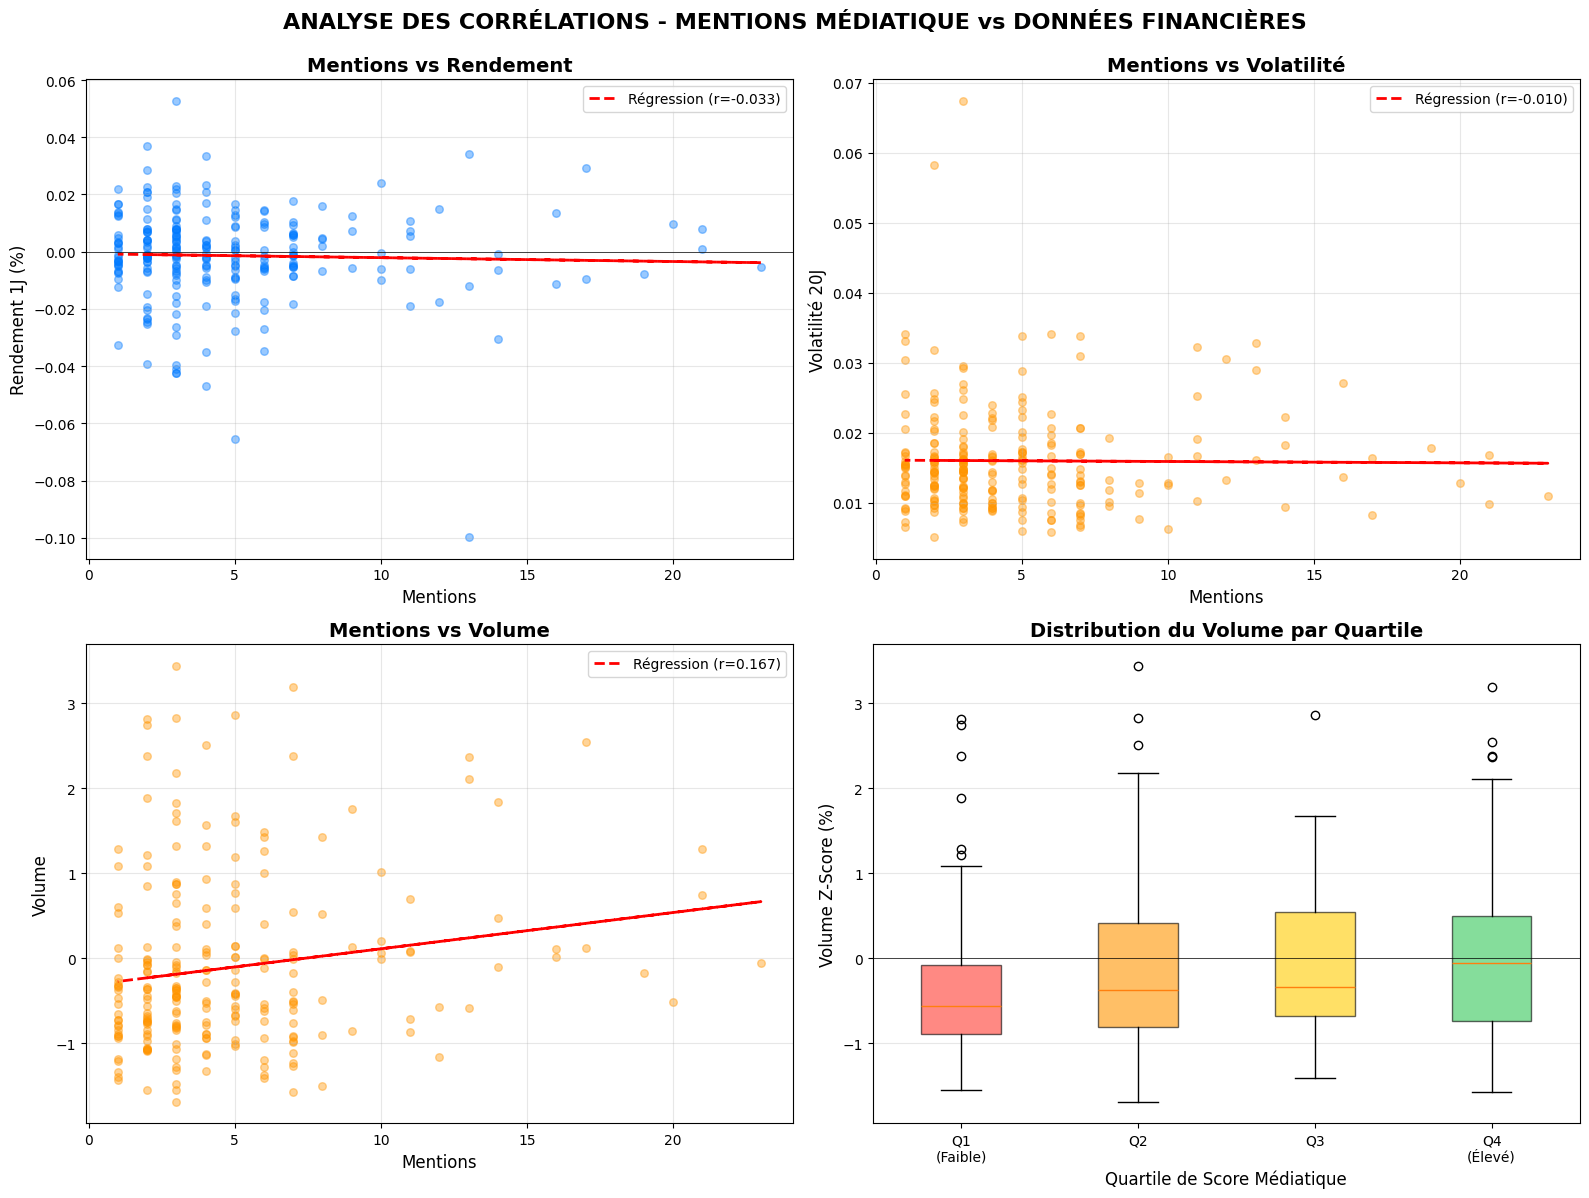

In [23]:
def analyze_media_finance_correlation(df_finance, df_media):
    """
    Fonction principale pour analyser les corrélations
    
    Parameters:
    -----------
    df_finance : DataFrame Yahoo Finance avec colonnes ['Date', 'Close', 'R1J', 'Volatilite 20J', 'volume_zscore']
    df_media : DataFrame score médiatique (résultat de GDELTMediaScore)
    """
    
    
    # Initialisation
    analyzer = MediaFinanceCorrelation(df_finance, df_media)
    
    # 1. Préparation des données
    df_merged = analyzer.prepare_data()
    
    # 2. Corrélations
    corr_pearson, corr_spearman = analyzer.compute_correlations()
    
    # 3. Analyse par quartiles
    quartile_stats = analyzer.quartile_analysis()
    
    # 4. Visualisation
    analyzer.visualize_correlations(corr_pearson, corr_spearman)
    
    return df_merged, corr_pearson




df_merged, correlations= analyze_media_finance_correlation(df_finance, df_media)


Le graphique d'analyse des corrélations révèle qu'il existe une faible déconnexion entre le bruit médiatique entourant Apple et la réaction immédiate de son action en Bourse. Le volume des mentions médiatiques (les pics d'actualité) n'a pratiquement aucune corrélation avec le rendement de l'action ($r = -0.033$) ni avec sa volatilité à court terme ($r = -0.010$), ce qui suggère que les investisseurs institutionnels ne se laissent pas facilement influencer par le buzz du jour pour modifier significativement leurs prix. Cependant, le volume de mentions présente une faible corrélation positive avec le volume de transactions ($r = 0.167$), une tendance confirmée par l'analyse par quartiles : les jours de forte médiatisation (Q4) affichent systématiquement un volume d'échanges plus élevé. Cela indique que l'attention médiatique agit comme un catalyseur d'activité pour les traders et le public, incitant plus de personnes à acheter ou vendre, sans pour autant déterminer la direction nette du prix (hausse ou baisse).